# Single Shot Multibox Detection


## Reference

+ [Dive into deep learning, Chapter 13.7](https://d2l.ai/chapter_computer-vision/ssd.html)

+ [d2l package, PyTorch version](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py)

+ [PyTorch docs](https://pytorch.org/docs/stable/index.html)

+ [PaddlePaddle docs](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/index_cn.html)

In [1]:
!nvidia-smi

Mon Apr 25 13:32:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   42C    P0    65W / 300W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model constructing

### Class Prediction Layer

In [2]:
%matplotlib inline
import paddle
import paddle.vision
from paddle import nn
from paddle.nn import functional as F

from matplotlib import pyplot as plt
# import d2l.torch as d2l

In [3]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2D(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [4]:
cls_predictor(num_inputs=8, num_anchors=5, num_classes=10)

W0425 13:32:49.576177  2991 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0425 13:32:49.581765  2991 device_context.cc:465] device: 0, cuDNN Version: 7.6.


Conv2D(8, 55, kernel_size=[3, 3], padding=1, data_format=NCHW)

### Bounding Box Prediction Layer

In [5]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2D(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [6]:
bbox_predictor(num_inputs=8, num_anchors=5)

Conv2D(8, 20, kernel_size=[3, 3], padding=1, data_format=NCHW)

### Concatenating Predictions for Multiple Scales

In [7]:
def forward(x, block):
    return block(x)

Y1 = forward(paddle.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(paddle.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

([2, 55, 20, 20], [2, 33, 10, 10])

In [8]:
def flatten_pred(pred):
    return paddle.flatten(paddle.transpose(pred, perm=[0, 2, 3, 1]), start_axis=1)

def concat_preds(preds):
    return paddle.concat([flatten_pred(p) for p in preds], axis=1)

In [9]:
concat_preds([Y1, Y2]).shape

[2, 25300]

### Downsampling Block

In [10]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2D(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2D(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2D(2))
    return nn.Sequential(*blk)

In [11]:
forward(paddle.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[2, 10, 10, 10]

### Base Network Block

In [12]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(paddle.zeros((2, 3, 256, 256)), base_net()).shape

[2, 64, 32, 32]

### The Complete Model

In [13]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2D((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [14]:
def box_corner_to_center(boxes):
    """Convert from (upper_left, bottom_right) to (center, width, height)"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = paddle.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper_left, bottom_right)"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = paddle.stack((x1, y1, x2, y2), axis=-1)
    return boxes


# Defined in file: ./chapter_computer-vision/bounding-box.md
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)


# Defined in file: ./chapter_computer-vision/anchor.md
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = paddle.to_tensor(sizes)
    ratio_tensor = paddle.to_tensor(ratios)
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (paddle.arange(in_height) + offset_h) * steps_h
    center_w = (paddle.arange(in_width) + offset_w) * steps_w
    shift_y, shift_x = paddle.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape([-1]), shift_x.reshape([-1])

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    # cat (various sizes, first ratio) and (first size, various ratios)
    w = paddle.concat((size_tensor * paddle.sqrt(ratio_tensor[0]),
                   sizes[0] * paddle.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # handle rectangular inputs
    h = paddle.concat((size_tensor / paddle.sqrt(ratio_tensor[0]),
                   sizes[0] / paddle.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = paddle.tile(paddle.t(paddle.stack([-w, -h, w, h])), repeat_times=[in_height * in_width, 1]) /2

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = paddle.tile(paddle.stack([shift_x, shift_y, shift_x, shift_y],
                axis=1), repeat_times=[boxes_per_pixel, 1])

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [16]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [17]:
class TinySSD(nn.Layer):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = paddle.concat(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        # print((cls_preds.shape[0], -1, self.num_classes + 1))
        cls_preds = cls_preds.reshape([cls_preds.shape[0], -1, self.num_classes + 1])
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [18]:
net = TinySSD(num_classes=1)
# model = paddle.Model(net)
X = paddle.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: [1, 5444, 4]
output class preds: [32, 5444, 2]
output bbox preds: [32, 21776]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:




## Data preparing

In [19]:
!unzip -oq /home/aistudio/data/banana-detection.zip

In [20]:
import os
import pandas as pd
import cv2
import numpy as np

def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = 'banana-detection'
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                                    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        img = cv2.imread(os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (img / 255.0 - mean) / std
        img = img.astype('float32').transpose((2, 0, 1))
        images.append(img)
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return paddle.to_tensor(images), paddle.to_tensor(targets).unsqueeze(1) / 256

class BananasDataset(paddle.io.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

    def __len__(self):
        return len(self.features)

banana =  BananasDataset(is_train=True)
for features, target in banana:
    print("Type of features is:", type(features))
    print("Shape of features is:", features.shape)
    print("Type of target is:", type(target))
    print("Shape of target is:", target.shape)
    break

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


read 1000 training examples
Type of features is: <class 'paddle.Tensor'>
Shape of features is: [3, 256, 256]
Type of target is: <class 'paddle.Tensor'>
Shape of target is: [1, 5]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


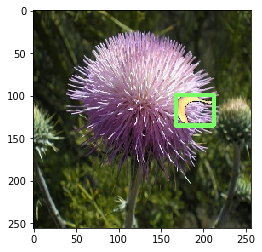

In [21]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

i = 1
for data, label in banana:

    if i == 7:
        image = data.numpy().transpose((1, 2, 0))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = label.numpy() * 256
        cv2.rectangle(image, (int(label[0][1]), int(label[0][2])), (int(label[0][3]), int(label[0][4])), (0, 255, 0), 4)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = (image * std + mean) * 255.0 
        image = image.astype('int64')
        plt.imshow(image)
        plt.show()
        break

    i += 1

In [22]:
train_loader = paddle.io.DataLoader(banana, batch_size=32, shuffle=True)
for batch_id, data in enumerate(train_loader()):
    x_data = data[0]
    y_data = data[1]

    print("image shape:{}".format(x_data.shape))
    print("label shape:{}".format(y_data.shape))
    break

image shape:[32, 3, 256, 256]
label shape:[32, 1, 5]


## Training

### Reading the Dataset and Initializing the Model

In [23]:
net = TinySSD(num_classes=1)
# trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)
trainer = paddle.optimizer.SGD(learning_rate=0.2, parameters=net.parameters(), weight_decay=5e-4)

### Defining Loss and Evaluation Functions

In [24]:
# cls_loss = nn.CrossEntropyLoss(reduction='none')
# bbox_loss = nn.L1Loss(reduction='none')

# def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
#     batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
#     cls = cls_loss(cls_preds.reshape((-1, num_classes)),
#                    cls_labels.reshape((-1,))).reshape((batch_size, -1))
#     bbox = bbox_loss(bbox_preds * bbox_masks,
#                      bbox_labels * bbox_masks)
#     return cls + bbox

cls_loss = nn.CrossEntropyLoss()
bbox_loss = nn.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape([-1, num_classes]), cls_labels.reshape([-1]))
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks)
    return cls + bbox

In [25]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(axis=-1) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((paddle.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### Training the Model

In [26]:
def box_iou(boxes1, boxes2):
    boxes1, boxes2 = np.array(boxes1), np.array(boxes2)
    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = np.maximum(rb - lt + 1, 0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    areas1 = (boxes1[:, 2] - boxes1[:, 0] + 1) * (boxes1[:, 3] - boxes1[:, 1] + 1)
    areas2 = (boxes2[:, 2] - boxes2[:, 0] + 1) * (boxes2[:, 3] - boxes2[:, 1] + 1)
    iou = inter / (areas1[:, None] + areas2 - inter)
    return paddle.to_tensor(iou)

def match_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = paddle.full((num_anchors,), -1, dtype="int64")
    # Assign ground truth bounding box according to the threshold
    max_ious = paddle.max(jaccard)
    indices = paddle.argmax(jaccard)
    anc_i = paddle.nonzero(max_ious >= 0.5)
    box_j = indices[0]
    anchors_bbox_map[anc_i] = box_j
    # Find the largest iou for each bbox
    col_discard = paddle.full((num_anchors,), -1)
    row_discard = paddle.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = paddle.argmax(jaccard)
        box_idx = paddle.cast(max_idx % num_gt_boxes, dtype='int64')# (max_idx % num_gt_boxes)#.long()
        anc_idx = paddle.cast(max_idx / num_gt_boxes, dtype='int64')# (max_idx / num_gt_boxes)#.long()
        anchors_bbox_map[anc_idx] = box_idx
    return anchors_bbox_map

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * paddle.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = paddle.concat([offset_xy, offset_wh], axis=1)
    return offset

def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors)
        bbox_mask = (paddle.cast((anchors_bbox_map >= 0), dtype='float64').unsqueeze(-1))
        bbox_mask = paddle.tile(bbox_mask, repeat_times=[1, 4])
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = paddle.zeros([num_anchors], dtype="int64")
        assigned_bb = paddle.zeros([num_anchors, 4], dtype="float32")
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = paddle.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = paddle.cast(label[0][0], dtype="int64") + 1
        assigned_bb[indices_true] = label[0][1:]
        # offset transformations
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape([-1]))
        batch_mask.append(bbox_mask.reshape([-1]))
        batch_class_labels.append(class_labels)
    bbox_offset = paddle.stack(batch_offset)
    bbox_mask = paddle.stack(batch_mask)
    class_labels = paddle.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
num_epochs = 42

for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = Accumulator(4)
    net.train()
    for i, (features, target) in enumerate(train_loader()):
        trainer.clear_grad()
        X, Y = features, target
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f'epoch: {epoch}, loss: {l.mean().numpy()[0]}, class err: {cls_err:.2e}, bbox mae: {bbox_mae:.2e}')

epoch: 0, loss: 0.005333421751856804, class err: 3.64e-04, bbox mae: 2.41e-03
epoch: 1, loss: 0.0044654859229922295, class err: 3.63e-04, bbox mae: 2.41e-03
epoch: 2, loss: 0.004946250468492508, class err: 3.61e-04, bbox mae: 2.40e-03
epoch: 3, loss: 0.004618683829903603, class err: 3.61e-04, bbox mae: 2.40e-03
epoch: 4, loss: 0.004523834213614464, class err: 3.59e-04, bbox mae: 2.40e-03
epoch: 5, loss: 0.005075016058981419, class err: 3.59e-04, bbox mae: 2.39e-03
epoch: 6, loss: 0.0049829501658678055, class err: 3.55e-04, bbox mae: 2.39e-03
epoch: 7, loss: 0.004452131688594818, class err: 3.54e-04, bbox mae: 2.38e-03
epoch: 8, loss: 0.004827508237212896, class err: 3.52e-04, bbox mae: 2.38e-03
epoch: 9, loss: 0.0042803483083844185, class err: 3.50e-04, bbox mae: 2.37e-03
epoch: 10, loss: 0.005187014117836952, class err: 3.48e-04, bbox mae: 2.37e-03
epoch: 11, loss: 0.0048626260831952095, class err: 3.46e-04, bbox mae: 2.37e-03
epoch: 12, loss: 0.004715502727776766, class err: 3.43e-04

## Prediction

### Load Test Data for Predicting

In [30]:
banana_test = BananasDataset(is_train=False)

read 100 validation examples


### Predict Bounding Box

Obtain the predicted bounding boxesfrom the anchor boxes and their predicted offsets. Then non-maximum suppression is used to remove similar predicted bounding boxes.

In [31]:
def offset_inverse(anchors, offset_preds):
    c_anc = box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = paddle.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = paddle.concat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = paddle.argsort(scores, axis=-1, descending=True)
    keep = []  # boxes indices that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() <= 1: break
        iou = box_iou(boxes.numpy()[i.numpy(), :].reshape([-1, 4]), boxes.numpy()[B.numpy()[1:], :].reshape([-1, 4])).reshape([-1])
        if paddle.nonzero(iou <= iou_threshold).shape[0] == 0: break
        inds = paddle.nonzero(iou <= iou_threshold).reshape([-1])
        B = B[inds + 1]
    return paddle.to_tensor(keep).reshape([-1])

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    batch_size = cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape([-1, 4])
        conf = paddle.max(cls_prob[1:], 0)
        class_id = paddle.argmax(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        all_idx = paddle.arange(num_anchors, dtype="int64")
        combined = paddle.concat([keep, all_idx], axis=0)
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = paddle.concat([keep, non_keep], axis=0)
        class_id[non_keep.stop_gradient] = -1.
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # # print(conf, predicted_bb)
        # # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx.stop_gradient] = -1.
        conf[below_min_idx] = 1. - conf[below_min_idx]
        pred_info = paddle.concat([paddle.cast(class_id.unsqueeze(1), 'float32'), conf.unsqueeze(1), predicted_bb], axis=1)
        out.append(pred_info)
    return paddle.stack(out)

In [32]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X)
    cls_probs = F.softmax(cls_preds, axis=2)
    cls_probs = paddle.transpose(cls_probs, perm=[0, 2, 1])
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output

In [33]:
test_loader = paddle.io.DataLoader(banana_test, batch_size=1, shuffle=True)
for batch_id, data in enumerate(test_loader()):
    X = data[0]
    Y = predict(X)
    break

### Preidicting Result

Finally, we display all the predicted bounding boxes with confidence 0.9 or above as the output.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
[-1.          0.99999976  0.10772859  0.29449373  0.53791505  0.7060737 ]


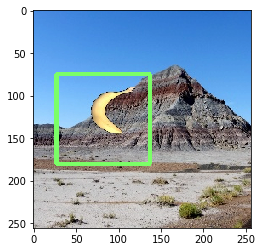

In [34]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = X[0].numpy().transpose((1, 2, 0))
print(image.shape)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
outputs = Y.numpy()[0]
results = []

for output in outputs:
    if (output[2] > 0. and output[2] < 1.) and (output[3] > 0. and output[3] < 1.) and (output[4] > 0. and output[4] < 1.) and (output[5] > 0. and output[5] < 1.) and output[1] < 1.:
        results.append(output)
results = np.array(results)
results = results[np.argsort(results[:,1])]
output = results[-1]
print(output)

cv2.rectangle(image, (int(output[2]*256), int(output[3]*256)), (int(output[4]*256), int(output[5]*256)), (0, 255, 0), 4)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image * std + mean) * 255.0
image = image.astype('int64')
plt.imshow(image)
plt.show()